# Tagup data science challenge

ExampleCo, Inc has a problem: maintenance on their widgets is expensive. They have contracted with Tagup to help them implement predictive maintenance. They want us to provide a model that will allow them to prioritize maintenance for those units most likely to fail, and in particular to gain some warning---even just a few hours!---before a unit does fail.

They collect two kinds of data for each unit. First, they have a remote monitoring system for the motors in each unit, which collects information about the motor (rotation speed, voltage, current) as well as two temperature probes (one on the motor and one at the inlet). Unfortunately, this system is antiquated and prone to communication errors, which manifest as nonsense measurements. Second, they have a rule-based alarming system, which can emit either warnings or errors; the system is known to be noisy, but it's the best they've got. 

They have given us just over 100MB of historical remote monitoring data from twenty of their units that failed in the field. The shortest-lived units failed after a few days; the longest-lived units failed after several years. Typical lifetimes are on the order of a year. This data is available in .csv files under `data/train` in this repository. In addition, they have provided us with operating data from their thirty active units for the past month; this data is available under `data/test` in this repository.

You have two main objectives. First, **tell us as much as you can about the process that generated the data**. Does it show meaningful clustering? Do the observations appear independent? How accurately can we forecast future observations, and how long a window do we need to make an accurate forecast? Feel free to propose multiple models, but be sure to discuss the ways each is useful and the ways each is not useful. Second, **predict which of the thirty active units are most likely to fail**. The data from these units are in `data/test`. Be sure to quantify these predictions, and especially your certainty.

A few notes to help:
1. A good place to start is by addressing the noise due to comm errors. 
2. There is a signal in the data that you can identify and exploit to predict failure. Each machine failed immediately after the last recorded timestamp in the remote monitoring timeseries data.
3. If you can't find the signal in the noise, don't despair! We're much more interested in what you try and how you try it than in how successful you are at helping a fictional company with their fictional problems.
4. Feel free to use any libraries you like, or even other programming languages. Your final results should be presented in this notebook, however.
5. There are no constraints on the models or algorithms you can bring to bear. Some ideas include: unsupervised clustering algorithms such as k-means; hidden Markov models; forecasting models like ARMA; neural networks; survival models built using features extracted from the data; etc.
6. Don't feel compelled to use all the data if you're not sure how. Feel free to focus on data from a single unit if that makes it easier to get started.
7. Be sure to clearly articulate what you did, why you did it, and how the results should be interpreted. In particular you should be aware of the limitations of whatever approach or approaches you take.
8. Don't hesitate to reach out with any questions.

In [ ]:
#!pip3 install statsmodels

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
count,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04
mean,-8.111152e+46,-4.431337e+60,-1.387827e+56,-6.640742e+69,-1.937422e+48
std,2.456380e+49,1.903274e+63,4.202968e+58,2.011115e+72,5.867349e+50
min,-7.439020e+51,-5.565298e+65,-1.272847e+61,-6.090557e+74,-1.776896e+53
25%,1.017725e+03,2.311319e+02,3.239347e+01,1.179731e+02,6.489677e+01
50%,1.066347e+03,2.667104e+02,3.944687e+01,1.564521e+02,7.799157e+01
75%,1.106721e+03,2.993994e+02,4.607173e+01,1.978223e+02,9.086132e+01
max,7.978110e+44,1.500194e+65,1.555360e+55,3.117856e+55,1.710299e+40


,message
count,4
unique,4
top,warning
freq,1


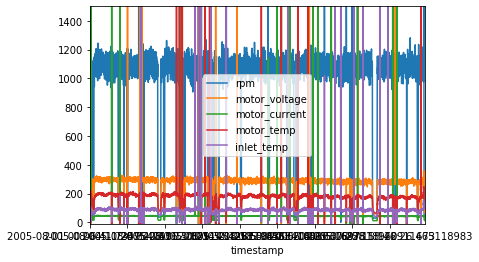

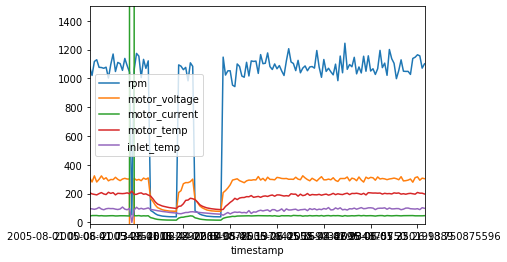

In [34]:
# To help you get started...
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

def load_rms(filename):
    return pd.read_csv(filename, index_col="timestamp")
def load_alarms(filename):
    return pd.read_csv(filename, header=None, names=["timestamp", "message"], index_col="timestamp").describe()

rms = load_rms('data/train/unit0000_rms.csv')
alarms = load_alarms('data/train/unit0000_alarms.csv')
rms.loc["2005-08-01":"2005-09-01"].plot(ylim=(-10, 1500))
rms.loc["2005-08-01":"2005-08-02"].plot(ylim=(-10, 1500))

display(rms.describe())
display(alarms.describe())

### ARIMA Approach

In [10]:
rms.head(5)

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
timestamp,,,,,
2003-12-13 19:56:43.777979848,0.150438,-0.059544,0.045503,5.084823,0.019528
2003-12-13 20:07:32.457298714,0.511660,0.627101,0.208669,7.334172,2.081454
2003-12-13 20:13:43.182783330,0.824233,1.732618,0.286401,8.843053,3.485346
2003-12-13 20:27:19.295198297,1.506626,3.115258,0.483992,11.749493,6.041188
2003-12-13 20:35:08.719032171,2.034869,3.923323,0.851620,12.947061,7.309662


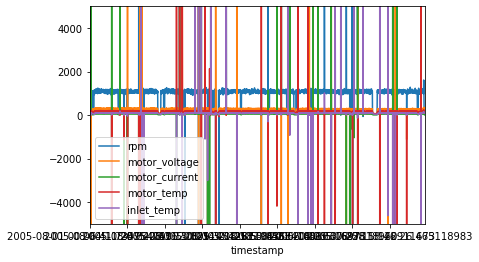

<Figure size 2520x2520 with 0 Axes>

In [19]:
rms.loc["2005-08-01":"2005-09-01"].plot(ylim=(-5000, 5000))
plt.figure(figsize=(35,35))
plt.show()

In [23]:
from statsmodels.tsa.arima_model import ARIMA

In [25]:
model = ARIMA(rms)
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

TypeError: __new__() missing 1 required positional argument: 'order'

In [26]:
?ARIMA

In [27]:
import warnings
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# load dataset

# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMANone MSE=inf


In [30]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

FileNotFoundError: [Errno 2] File b'shampoo-sales.csv' does not exist: b'shampoo-sales.csv'

In [46]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='kempegowda.a', api_key='cF870W5z9vOzGeP0O5iv')

In [58]:
alarms.reset_index(level=0, inplace=True)

In [60]:
alarms.head()

,index,message
0,count,305
1,unique,2
2,top,warning
3,freq,304


In [55]:
rpm = go.Scatter(
    x=rms.timestamp,
    y=rms['rpm'],
    name = "RPM",
    line = dict(color = '#17BECF'),
    opacity = 0.8)

motor_voltage = go.Scatter(
    x=rms.timestamp,
    y=rms['motor_voltage'],
    name = "Motor Voltage",
    line = dict(color = '#7F7F7F'),
    opacity = 0.8)

motor_current = go.Scatter(
    x=rms.timestamp,
    y=rms['motor_current'],
    name = "Motor Current",
    line = dict(color = '#d62728'),
    opacity = 0.8)

motor_temp = go.Scatter(
    x=rms.timestamp,
    y=rms['motor_temp'],
    name = "Motor Temperature",
    line = dict(color = '#e377c2'),
    opacity = 0.8)

inlet_temp = go.Scatter(
    x=rms.timestamp,
    y=rms['inlet_temp'],
    name = "Inlet Temperature",
    line = dict(color = '#ff7f0e'),
    opacity = 0.8)

motor_data = [rpm,motor_voltage, motor_current, motor_temp,inlet_temp]

layout = dict(
    title='Time Series with Rangeslider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='30m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=motor_data, layout=layout)
py.iplot(fig, filename = "(RMS)Motor-1 Time series Range slider")


The draw time for this plot will be slow for all clients.


In [50]:
rpm = go.Scatter(
    x=rms.timestamp,
    y=rms['rpm'],
    name = "RPM",
    line = dict(color = '#17BECF'),
    opacity = 0.8)

motor_voltage = go.Scatter(
    x=rms.timestamp,
    y=rms['motor_voltage'],
    name = "Motor Voltage",
    line = dict(color = '#7F7F7F'),
    opacity = 0.8)

motor_current = go.Scatter(
    x=rms.timestamp,
    y=rms['motor_current'],
    name = "Motor Current",
    line = dict(color = '#d62728'),
    opacity = 0.8)

motor_temp = go.Scatter(
    x=rms.timestamp,
    y=rms['motor_temp'],
    name = "Motor Temperature",
    line = dict(color = '#e377c2'),
    opacity = 0.8)

inlet_temp = go.Scatter(
    x=rms.timestamp,
    y=rms['inlet_temp'],
    name = "Inlet Temperature",
    line = dict(color = '#ff7f0e'),
    opacity = 0.8)

motor_data = [rpm,motor_voltage, motor_current, motor_temp,inlet_temp]

layout = dict(
    title='Time Series with Rangeslider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='30m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=motor_data, layout=layout)
py.iplot(fig, filename = "(RMS)Motor-1 Time series Range slider")


                           timestamp          rpm  motor_voltage  \
0      2003-12-13 19:56:43.777979848     0.150438      -0.059544   
91714  2005-09-10 17:36:47.236452969  1066.459970     252.919940   

       motor_current  motor_temp  inlet_temp  
0           0.045503    5.084823    0.019528  
91714      36.583988  140.631292   73.711883  


In [61]:
from sklearn.cluster import KMeans

In [69]:
preds = KMeans(n_clusters=2, random_state=0).fit(rms[['rpm', 'motor_voltage', 'motor_current','motor_temp', 'inlet_temp']])

In [72]:
km = KMeans(n_clusters=2,
           init='k-means++',
           n_init=10,
           max_iter=1000,
           tol=1e-04,
           random_state=0)
y_km = km.fit_predict(rms[['rpm', 'motor_voltage', 'motor_current','motor_temp', 'inlet_temp']])

TypeError: unhashable type: 'numpy.ndarray'

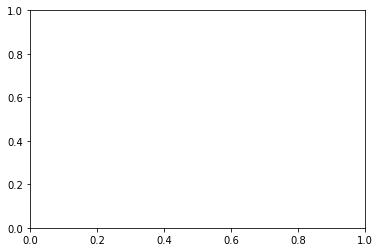

In [74]:
plt.scatter(rms[['timestamp']], y_km)